<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Signal to Binary Files (Train&Test) 

In this notebook we read the Basic 4 dataset and convert signals into a binary file. The format of output binary file is same as MNIST.

In [18]:
#!sudo pip install ibmseti

In [19]:
import requests
import json
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
from PIL import Image
from matplotlib import cm
from array import array

Lets first create a working folder:

In [20]:
ds_directory = 'tmp/SETI-data/'  # The dataset directory to write the binary files
if not os.path.exists(ds_directory):
    os.makedirs(ds_directory)
# remove its content
os.system('rm '+ds_directory+'*')
print os.popen("ls -lrt "+ ds_directory).read()


total 0



### Get file list

I have a list of simulated files stored in an OpenStack Object Storage container that is world-readable.

In [21]:
# Images
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals_basic_v2'
# list of images
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_basic_v2_26may_2017.csv')
filelist_txt = r.text

Lets create a generator to read the file:

In [22]:
def filetext_gen(filelist_txt):
    results = filelist_txt.splitlines()[1:]
    for result in results:
        yield result

This file has 4 classes:

In [23]:
dictClass = dict({u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0})
dictClass

{u'narrowband': 2, u'narrowbanddrd': 1, u'noise': 3, u'squiggle': 0}

# Train/Test
    
    

In [24]:
#At first, use just 20 percent and 10 percent. This will be useful 
#as you prototype. Then you can come back here and increase these
#percentages as needed.

training_percentage = 0.20
test_percentage = 0.10

assert training_percentage + test_percentage <= 1.0

number of files:

In [25]:
uuids_classes_as_list = map(lambda row:row, filetext_gen(filelist_txt))
print "found {} files".format(len(uuids_classes_as_list))

found 4000 files


Files grouped by classes:

In [26]:
uuids_group_by_class={}
for item in filetext_gen(filelist_txt): 
    uuid, sigclass =  item.split(',')
    uuids_group_by_class.setdefault(sigclass, []).append(item)


split into test and train based on classes:

In [27]:
training_set_group_by_class = {}
test_set_group_by_class = {}
for k, v in uuids_group_by_class.iteritems():
    
    total = len(v)
    training_size = int(total * training_percentage)
    test_size = int(total * test_percentage)
    
    training_set = v[:training_size]
    test_set = v[-1*test_size:]
    
    training_set_group_by_class[k] = training_set
    test_set_group_by_class[k] = test_set
    
    print '{}: training set size: {}'.format(k, len(training_set))
    print '{}: test set size: {}'.format(k, len(test_set))
    

squiggle: training set size: 200
squiggle: test set size: 100
narrowband: training set size: 200
narrowband: test set size: 100
noise: training set size: 200
noise: test set size: 100
narrowbanddrd: training set size: 200
narrowbanddrd: test set size: 100


In [28]:
all_training_set = []
for k, v, in training_set_group_by_class.iteritems():
    print k
    for item in v:
        all_training_set.append(item)
print 'number of files in the training set:' , len(all_training_set)

squiggle
narrowband
noise
narrowbanddrd
number of files in the training set: 800


In [29]:
all_test_set = []
for k, v, in test_set_group_by_class.iteritems():
    print k
    for item in v:
        all_test_set.append(item)
print 'number of files in the test set:' ,  len(all_test_set)

squiggle
narrowband
noise
narrowbanddrd
number of files in the test set: 400


###  Send request for data, and convert signals to spectogram

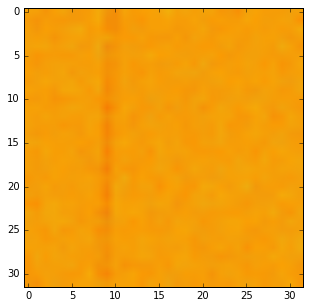

In [30]:
def get_spectrogram(fname,h,w,lengthRatio=1.0):
    
    r = requests.get('{}/{}/{}'.format(base_url, container, fname), timeout=4.0)
    if r.status_code != 200:
        print 'Failed retrieving {}'.format(fname)
        print r
        return None
    else:
        aca = ibmseti.compamp.SimCompamp(r.content)
        com_data = aca.complex_data()
        ratio = int(np.sqrt(len(com_data) *lengthRatio / (h*w)))
        if ratio == 0: 
            raise ValueError, "The selected lenght of signal is less than (Height x Width), select bigger ratio"
        elif ratio == 1:
            sig_data = com_data[:h*w].reshape(h,w)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec)
            spec = spec/np.max(spec) # Convert to float (0-1)
            image = Image.fromarray(cm.jet(spec, bytes=True)) #convert to RGB
        elif ratio > 1: # resize using IPL image
            sig_data = com_data[:h*ratio*w*ratio].reshape(h*ratio,w*ratio)
            spec = np.abs( np.fft.fftshift( np.fft.fft(sig_data), 1) )**2
            spec = np.log(spec) # Convert to float (0-255)
            spec = spec/np.max(spec) # Convert to float (0-1)
            image = Image.fromarray(cm.jet(spec, bytes=True)) #convert to RGB  
            image = image.resize((int(w), int(h)), Image.ANTIALIAS)

        
        return image
#test

img_spec = get_spectrogram('b1cc342f-eae4-442b-91de-10c9a444072e.dat',32,32, 1.0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img_spec)

#### Grayscale image

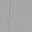

In [31]:
img = img_spec.convert("L")
imgarr = np.array(img, dtype=np.uint8) 
im = Image.fromarray(np.uint8(imgarr))
im


In [32]:
imgarr.flatten()

array([169, 168, 161, ..., 167, 172, 163], dtype=uint8)

h and w are the hight and width of the images, and lengthRatio is the length of signal in ratio.

In [33]:
h = 32 # The hight of output image (bins)
w = 32 # The witdh of output image
lengthRatio = 1.0  # the length-ration of signal to be read. The higher reatio, the better resolution. E.g. 0.5 means half of time sereis.

## Write to Binary file
This binary file is same as famouse __mnist__ dataset format to be read by different image processing algorithms, learning techniques and pattern recognition methods. 

There are 4 files:  

- train-images-idx3-ubyte: training set images 
- train-labels-idx1-ubyte: training set labels 
- test-images-idx3-ubyte:  test set images 
- test-labels-idx1-ubyte:  test set labels


### Header generator

#### Notice:

- Header of Label file is 8 Bytes
- Each number (int-8bit), is one Byte in array(B)
- For header, the first 4 bytes is 2049 
- the second 4 bytes is the number of files
- for example, the header for 10 file is [0, 0, 8, 1, 0, 0, 0, 10]

In [34]:
def label_generator(ds_directory, name, data_set):
    counter = 0
    data_label = array('B')
    n = len(data_set)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6)  # the result is '0x000a'

    # header for label array
    #data_label.extend(lblData)
    lb_header = array('B')
    # in the next 3 lines we create 10 bytes header
    lb_header.extend([0,0,8,1,0,0])  # -> "{0:#0{1}x}".format(2049,6) = '0x0801'
    lb_header.append(int('0x'+hexval[2:][:2],16)) # it adds 2 bytes '0x00'
    lb_header.append(int('0x'+hexval[2:][2:],16)) # it adds 2 bytes '0x0a'
    print lb_header
    with open(ds_directory + name+'-labels-idx1-ubyte','wb+') as f:
        f.write(lb_header)
        for item in data_set: 
            uuid, sigclass =  item.split(',')
            f.write(np.uint8(dictClass[sigclass]))
            counter += 1
#             if counter > n:
#                 break
        print 'The number of labels written in the binary file', counter
            
    os.system('gzip '+ ds_directory + name +'-labels-idx1-ubyte ')
    print ('done!')

In [35]:
label_generator(ds_directory, 'train', all_training_set)
label_generator(ds_directory, 'test', all_test_set)

array('B', [0, 0, 8, 1, 0, 0, 3, 32])
The number of labels written in the binary file 800
done!
array('B', [0, 0, 8, 1, 0, 0, 1, 144])
The number of labels written in the binary file 400
done!


### Image generator

In [36]:
def image_generator(ds_directory, name, data_set):
    print 'writing to:',  ds_directory , name
    counter = 0

    data_image = array('B')

    n = len(data_set)

    # number of files in HEX
    hexval = "{0:#0{1}x}".format(n,6) 

    img_header = array('B')
    img_header.extend([0,0,8,1,0,0])
    img_header.append(int('0x'+hexval[2:][:2],16))
    img_header.append(int('0x'+hexval[2:][2:],16))
    if max([w,h]) <= 255:
        img_header.extend([0,0,0,h,0,0,0,w])
    else:
        hex_h = "{0:#0{1}x}".format(h,6)
        img_header.extend([0,0])
        img_header.append(int('0x'+hex_h[2:][:2],16))
        img_header.append(int('0x'+hex_h[2:][2:],16))
        hex_w = "{0:#0{1}x}".format(w,6)
        img_header.extend([0,0])
        img_header.append(int('0x'+hex_w[2:][:2],16))
        img_header.append(int('0x'+hex_w[2:][2:],16))
        #raise ValueError('Image exceeds maximum size: 256x256 pixels');
    img_header[3] = 3 # Changing MSB for image data (0x00000803)
    #print img_header


    with open(ds_directory+name+'-images-idx3-ubyte','wb+') as f:
        f.write(img_header)
        for item in data_set: 
            uuid, sigclass =  item.split(',')
            file_name = uuid +'.dat'
            #print file_name
            img_spec = get_spectrogram(file_name, h, w, lengthRatio)
            # convert to grayscale: int(0-255)
            gimg = img_spec.convert("L")
            imgarr = np.array(img, dtype=np.uint8) #convert to array
            flat_array = imgarr.flatten()
            f.write((flat_array))
            counter += 1
            if counter%100 == 0:
                print('Processed files: '+str(counter))
#             if counter > n:
#                 break
        print 'The number of images written in the binary file', counter
    print 'Compressing .. '
    os.system('gzip '+ ds_directory + name +'-images-idx3-ubyte '+ name +'-images-idx3-ubyte.gz')

In [37]:
image_generator(ds_directory, 'train', all_training_set)
image_generator(ds_directory, 'test', all_test_set)

writing to: tmp/SETI-data/ train
Processed files: 100
Processed files: 200
Processed files: 300
Processed files: 400
Processed files: 500
Processed files: 600
Processed files: 700
Processed files: 800
The number of images written in the binary file 800
Compressing .. 
writing to: tmp/SETI-data/ test
Processed files: 100
Processed files: 200
Processed files: 300
Processed files: 400
The number of images written in the binary file 400
Compressing .. 


## Verify the binary files
Lets read the binary file and plot an image

In [38]:
print os.popen("ls -lrt "+ ds_directory).read()

total 9
-rw-r--r-- 1 nimbix nimbix   65 Oct 20 19:27 train-labels-idx1-ubyte.gz
-rw-r--r-- 1 nimbix nimbix   63 Oct 20 19:27 test-labels-idx1-ubyte.gz
-rw-r--r-- 1 nimbix nimbix 4681 Oct 20 19:29 train-images-idx3-ubyte.gz
-rw-r--r-- 1 nimbix nimbix 2697 Oct 20 19:29 test-images-idx3-ubyte.gz



### Header read

In [39]:
import numpy as np
import gzip
def _read32(bytestream): # this function reads 4 Bytes (32 bit)
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0] # it reads 4 bytes, and convert it into intiger

with open(ds_directory+'train-labels-idx1-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
     print  _read32(bytestream)
     num_items = _read32(bytestream)
     print num_items
     buf = bytestream.read(num_items)
     labels = np.frombuffer(buf, dtype=np.uint8)
     print labels

2049
800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3

# Image read

In [40]:
import numpy as np
import gzip
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

with open(ds_directory+'train-images-idx3-ubyte.gz', 'rb') as f:
    with gzip.GzipFile(fileobj=f ) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        print(magic,num_images,rows,cols,)
        
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
# magic, num, rows, cols = struct.unpack(">IIII", bytestream.read(16))


(2051, 800, 32, 32)


F


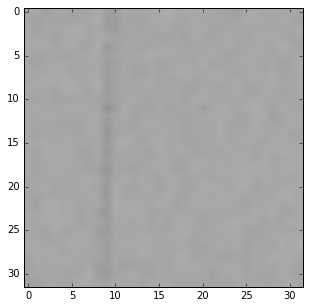

In [41]:
gray_y = data[0].reshape(h,w)
img = Image.fromarray(np.float32(gray_y))
print (img.mode)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

In [42]:
gray_y

array([[169, 168, 161, ..., 166, 167, 168],
       [165, 161, 166, ..., 169, 168, 161],
       [167, 162, 168, ..., 166, 167, 172],
       ..., 
       [162, 169, 166, ..., 169, 168, 163],
       [163, 166, 168, ..., 170, 166, 164],
       [163, 160, 168, ..., 167, 172, 163]], dtype=uint8)

### Verify the binary files by reader class
__SETI.py__ is a helper class, identical to mnist dataset reader, to easily read dataset, one-hot coding, and read images as batch.

In [43]:
!wget -q --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


In [44]:
SETIds = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
SETIds.train.num_examples

Extracting tmp/SETI-data/train-images-idx3-ubyte.gz
Extracting tmp/SETI-data/train-labels-idx1-ubyte.gz
Extracting tmp/SETI-data/test-images-idx3-ubyte.gz
Extracting tmp/SETI-data/test-labels-idx1-ubyte.gz


800

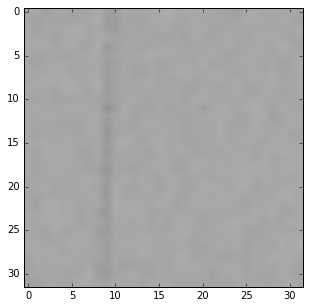

In [45]:
gray_y = SETIds.train.images[0].reshape(h,w)
img = Image.fromarray(gray_y*255)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(img)

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

